# Visualizing Better Multi-Modal Fused Embeddings of Image and Question Embeddings

In [1]:
import json
import torch
import numpy as np
from PIL import Image

import torch.nn.functional as F

from transformers import AutoImageProcessor, AutoModel
from transformers import BertModel, BertTokenizer

vqa_v2 = {
    'type': 'v2',
    'image_root': 'data/vqa-v2/val2014/val2014/COCO_val2014_000000',
    'questions_path': 'data/vqa-v2/v2_OpenEnded_mscoco_val2014_questions.json',
    'annotations_path': 'data/vqa-v2/v2_mscoco_val2014_annotations.json',
}

vqa_abs = {
    'type': 'abs',
    'image_root': 'data/vqa-abstract/img_train/abstract_v002_train2015_0000000',
    'questions_path': 'data/vqa-abstract/questions_train/OpenEnded_abstract_v002_train2015_questions.json',
    'annotations_path': 'data/vqa-abstract/annotations_train/abstract_v002_train2015_annotations.json',
}

cfg = {
    'n_classes': 25,
    'samples_per_answer': 100,
    'max_q_len': 23,
    'image_encoder': 'facebook/dinov2-base',
    'text_encoder': 'bert-base-uncased',
    
    'batch_size': 100,
    'epochs': 100,
    'base_lr': 0.001,

    'fusion_mode': 'cat',
}

In [2]:
from collections import defaultdict, deque

def data_processing(
        dataset, 
        n_classes=cfg['n_classes'], 
        samples_per_answer=cfg['samples_per_answer'],
        train_val_split=0.8):
    """
    Returns 
    1. list of {image_path, question, answer_id}
       -> train_data and val_data
       -> answer_id in the labels list given
       -> len = n_classes * samples_per_answer
    2. list of answer labels
       -> len = n_classes
    """

    with open(dataset['questions_path'], 'r') as file:
        questions = json.load(file)

    with open(dataset['annotations_path'], 'r') as file:
        annotations = json.load(file)

    questions = questions['questions']

    max_q_len = 0
    question_id_map = {}  # question_id : question_text
    for question in questions:
        question_id_map[question['question_id']] = question['question']
        max_q_len = max(max_q_len, len(question['question'].split()))

    print("Max question length = ", max_q_len)

    annotations = annotations['annotations']

    answers = defaultdict(list)  # answer : list of annotation indices
    for annotation in annotations:
        answers[annotation['multiple_choice_answer']] += [(annotation['image_id'], annotation['question_id'])]

    # filtering low occuring examples
    top_answers = deque(maxlen=n_classes)
    top_samples = deque(maxlen=n_classes)

    for answer, sample in answers.items():
        if len(sample) >= samples_per_answer and answer.isdigit() == False:
            top_answers.append(answer)
            top_samples.append(sample[:samples_per_answer])
    
    labels = list(sorted(top_answers))
    print(f'Labels = {labels}')

    train_data = []
    val_data = []
    for answer, samples in zip(top_answers, top_samples):
        for i, sample in enumerate(samples):
            image_id, question_id = sample
            if dataset['type'] == 'v2':
                image_id = str(image_id).zfill(6)
            elif dataset['type'] == 'abs':
                image_id = str(image_id).zfill(5)

            image_path = dataset['image_root'] + str(image_id) + '.jpg'
            question = question_id_map[question_id]

            data = train_data if i < train_val_split * len(samples) else val_data

            data.append({
                'image_path': image_path,
                'question': question,
                'answer_id': labels.index(answer)
            })

    print(f'Train size = {len(train_data)} | Val size = {len(val_data)} | Total = {len(train_data) + len(val_data)}')
    return train_data, val_data, labels

In [3]:
from torch.utils.data import Dataset, DataLoader, Subset

class VQADataset(Dataset):
    def __init__(self, data, image_encoder, text_encoder):
        self.data = data

        self.i_processor = AutoImageProcessor.from_pretrained(image_encoder)
        self.q_tokenizer = BertTokenizer.from_pretrained(text_encoder)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]

        idx_tr = torch.tensor(data_item['answer_id'])
        label = F.one_hot(idx_tr, num_classes=cfg['n_classes']).float()

        image = Image.open(data_item['image_path']).convert('RGB')
        
        i_tokens = self.i_processor(images=image, return_tensors='pt')
        q_tokens = self.q_tokenizer(
            data_item['question'], 
            padding="max_length", 
            max_length=cfg['max_q_len'], 
            truncation=True, 
            return_tensors='pt')

        # dirty way to fix dimention issue:
        i_tokens['pixel_values'] = i_tokens['pixel_values'].squeeze(0)

        for key, value in q_tokens.items():
            q_tokens[key] = value.squeeze(0)

        return i_tokens, q_tokens, label

In [4]:
import torch.nn as nn

class VLModel(nn.Module):
    def __init__(self, image_encoder, text_encoder, fusion_mode, embed_dim=768, output_dim=cfg['n_classes']):
        super(VLModel, self).__init__()

        self.fusion_mode = fusion_mode
        self.embed_dim = embed_dim

        self.i_encoder = AutoModel.from_pretrained(image_encoder)
        self.q_encoder = BertModel.from_pretrained(text_encoder)

        attn_heads = 4
        attn_embed_dim = 768
        self.attn_q2i = nn.MultiheadAttention(attn_embed_dim, attn_heads, batch_first=True)
        self.attn_i2q = nn.MultiheadAttention(attn_embed_dim, attn_heads, batch_first=True)
        
        self.attn_i = nn.MultiheadAttention(attn_embed_dim, attn_heads, batch_first=True)
        self.attn_q = nn.MultiheadAttention(attn_embed_dim, attn_heads, batch_first=True)

        if fusion_mode == 'cat': attn_embed_dim *= 2
        self.attn_e = nn.MultiheadAttention(attn_embed_dim, attn_heads, batch_first=True)

        if fusion_mode == 'cat': embed_dim *= 2
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim//2),
            nn.ReLU(),
            nn.LayerNorm(embed_dim//2),
            nn.Dropout(),
            nn.Linear(embed_dim//2, output_dim)
        )


    def forward(self, i_tokens, q_tokens):
        with torch.no_grad():
            i_embeddings = self.i_encoder(**i_tokens).last_hidden_state
            q_embeddings = self.q_encoder(**q_tokens).last_hidden_state

        i_attended, _ = self.attn_q2i(i_embeddings, q_embeddings, q_embeddings)
        q_attended, _ = self.attn_i2q(q_embeddings, i_embeddings, i_embeddings)

        i_embeddings = torch.zeros((i_attended.shape[0], 1, self.embed_dim)).cuda()
        i_embeddings, _ = self.attn_i(i_embeddings, i_attended, i_attended)

        q_embeddings = torch.zeros((q_attended.shape[0], 1, self.embed_dim)).cuda()
        q_embeddings, _ = self.attn_q(q_embeddings, q_attended, q_attended)

        if self.fusion_mode == 'cat':
            embedding = torch.cat((i_embeddings, q_embeddings), dim=-1)  # along channels
        elif self.fusion_mode == 'cat_v2':
            i_embeddings = i_embeddings.reshape(i_embeddings.shape[0], -1, self.embed_dim // 2)
            q_embeddings = q_embeddings.reshape(q_embeddings.shape[0], -1, self.embed_dim // 2)
            embedding = torch.cat((i_embeddings, q_embeddings), dim=-1)
        elif self.fusion_mode == 'mult':
            embedding = i_embeddings * q_embeddings
        elif self.fusion_mode == 'add':
            embedding = i_embeddings + q_embeddings

        zeros = torch.zeros((embedding.shape[0], 1, embedding.shape[-1])).cuda()
        embedding, _ = self.attn_e(zeros, embedding, embedding)
        embedding = embedding.squeeze(1)

        return self.ffn(embedding)

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def train(dataloader, model, criterion, optimizer):
    model.train()
    running_loss = 0.0

    for i, (i_tokens, q_tokens, label) in enumerate(dataloader):
        i_tokens = {key: value.cuda() for key, value in i_tokens.items()}
        q_tokens = {key: value.cuda() for key, value in q_tokens.items()}
        label = label.cuda()
        
        logits = model(i_tokens, q_tokens)

        loss = criterion(logits, label)
        running_loss += loss.item()

        if i % (len(dataloader)//4) == 0:
            print(f'\t Iter [{i}/{len(dataloader)}]\t Loss: {loss.item():.6f}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = running_loss / len(dataloader)

    return avg_loss


def eval(dataloader, model, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for i_tokens, q_tokens, label in dataloader:
            i_tokens = {key: value.cuda() for key, value in i_tokens.items()}
            q_tokens = {key: value.cuda() for key, value in q_tokens.items()}
            label = label.cuda()
            
            logits = model(i_tokens, q_tokens)

            loss = criterion(logits, label)
            running_loss += loss.item()

            probabilities = torch.sigmoid(logits).squeeze()
            predicted = (probabilities > 0.5).long()
            
            # Compute accuracy
            total += label.shape[0] * label.shape[1]
            correct += (predicted == label).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = (correct / total)
    
    return avg_loss, accuracy

In [6]:
def trainer(dataset):
    train_data, val_data, labels = data_processing(dataset)

    train_dataset = VQADataset(train_data, cfg['image_encoder'], cfg['text_encoder'])
    val_dataset = VQADataset(val_data, cfg['image_encoder'], cfg['text_encoder'])

    train_dataloader = DataLoader(train_dataset, batch_size=cfg['batch_size'], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=cfg['batch_size'], shuffle=False)

    print('len(train_dataloader) =', len(train_dataloader))

    model = VLModel(cfg['image_encoder'], cfg['text_encoder'], fusion_mode=cfg['fusion_mode']).cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg['base_lr'])
    scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=cfg['epochs'], power=0.9)

    train_losses, eval_losses, accuracies = [], [], []
    def plot(epoch):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        ax[0].plot(np.arange(epoch), train_losses, label='Train Loss')
        ax[0].plot(np.arange(epoch), eval_losses, label='Eval Loss')
        ax[0].legend()
        ax[0].set_title('Losses')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')

        ax[1].plot(np.arange(epoch), accuracies, label='Accuracy')
        ax[1].legend()
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')

        plt.show()

    for epoch in range(cfg['epochs']):
        train_loss = train(train_dataloader, model, criterion, optimizer)
        eval_loss, accuracy = eval(val_dataloader, model, criterion)
        scheduler.step()

        train_losses.append(train_loss)
        eval_losses.append(eval_loss)
        accuracies.append(accuracy)

        print(f'Epoch [{epoch+1}/{cfg['epochs']}]\t Avg Train Loss: {train_loss:.6f}\t Avg Eval Loss: {eval_loss:.6f}\t Avg Eval Accuracy: {accuracy:.2f}')

        if epoch > 0 and epoch % (cfg['epochs'] // 8) == 0:
            plot(epoch+1)

Max question length =  23
Labels = ['baseball', 'bathroom', 'black and white', 'cat', 'dog', 'frisbee', 'grass', 'horse', 'kitchen', 'kite', 'left', 'man', 'nothing', 'orange', 'pink', 'pizza', 'right', 'silver', 'skateboarding', 'skiing', 'surfing', 'tennis', 'water', 'wood', 'yellow']
Train size = 7000 | Val size = 1750 | Total = 8750
len(train_dataloader) = 24
	 Iter [0/24]	 Loss: 3.581653
	 Iter [6/24]	 Loss: 3.987464
	 Iter [12/24]	 Loss: 3.760483
	 Iter [18/24]	 Loss: 3.538717
Epoch [1/100]	 Avg Train Loss: 3.789453	 Avg Eval Loss: 3.152590	 Avg Eval Accuracy: 0.11
	 Iter [0/24]	 Loss: 3.204486
	 Iter [6/24]	 Loss: 3.200253
	 Iter [12/24]	 Loss: 2.952303
	 Iter [18/24]	 Loss: 2.739827
Epoch [2/100]	 Avg Train Loss: 2.973623	 Avg Eval Loss: 2.596477	 Avg Eval Accuracy: 0.32


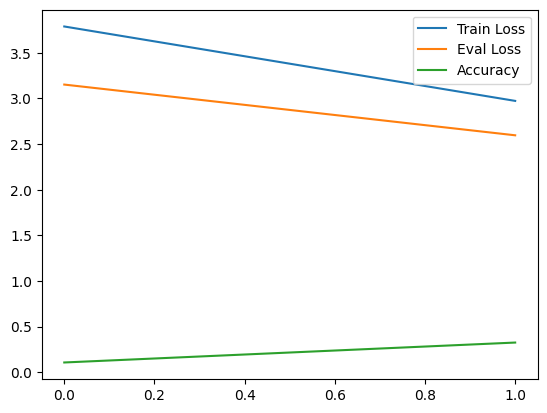

	 Iter [0/24]	 Loss: 2.725684
	 Iter [6/24]	 Loss: 2.691905
	 Iter [12/24]	 Loss: 2.568438
	 Iter [18/24]	 Loss: 2.408339
Epoch [3/100]	 Avg Train Loss: 2.536391	 Avg Eval Loss: 2.247816	 Avg Eval Accuracy: 0.40


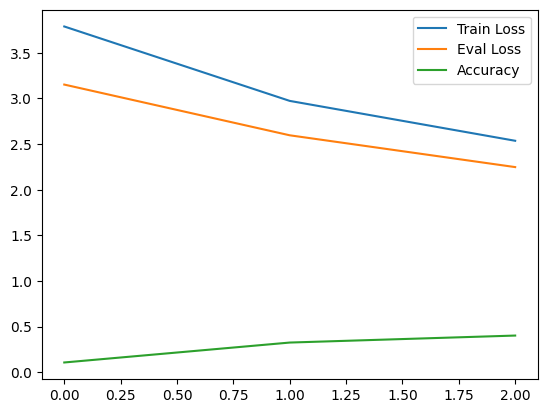

	 Iter [0/24]	 Loss: 2.378180
	 Iter [6/24]	 Loss: 2.312526
	 Iter [12/24]	 Loss: 2.337327
	 Iter [18/24]	 Loss: 2.101382
Epoch [4/100]	 Avg Train Loss: 2.261162	 Avg Eval Loss: 2.055234	 Avg Eval Accuracy: 0.48


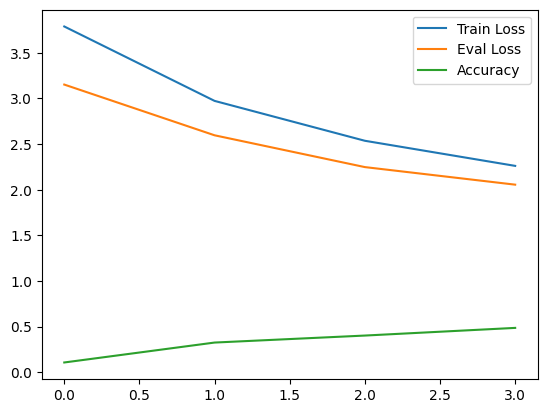

	 Iter [0/24]	 Loss: 1.967098
	 Iter [6/24]	 Loss: 1.882675
	 Iter [12/24]	 Loss: 1.840095
	 Iter [18/24]	 Loss: 2.006506
Epoch [5/100]	 Avg Train Loss: 1.922182	 Avg Eval Loss: 1.771382	 Avg Eval Accuracy: 0.47


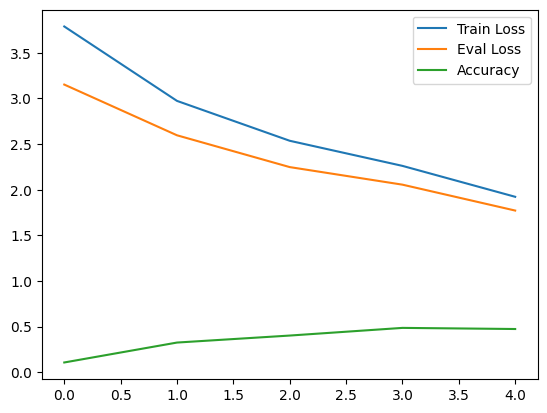

	 Iter [0/24]	 Loss: 1.785800
	 Iter [6/24]	 Loss: 1.838113
	 Iter [12/24]	 Loss: 1.753032
	 Iter [18/24]	 Loss: 1.674682
Epoch [6/100]	 Avg Train Loss: 1.781978	 Avg Eval Loss: 1.668186	 Avg Eval Accuracy: 0.48


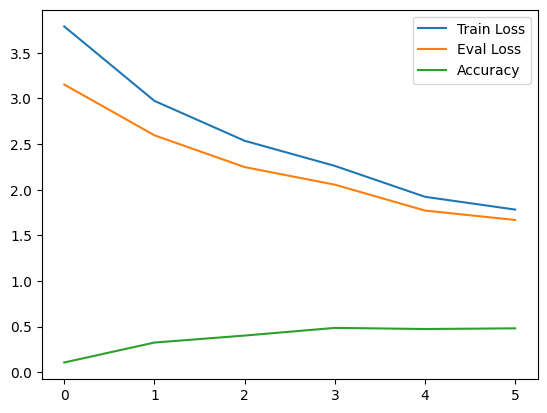

	 Iter [0/24]	 Loss: 1.679691
	 Iter [6/24]	 Loss: 1.596114
	 Iter [12/24]	 Loss: 1.657670
	 Iter [18/24]	 Loss: 1.995595
Epoch [7/100]	 Avg Train Loss: 1.795595	 Avg Eval Loss: 1.822540	 Avg Eval Accuracy: 0.50


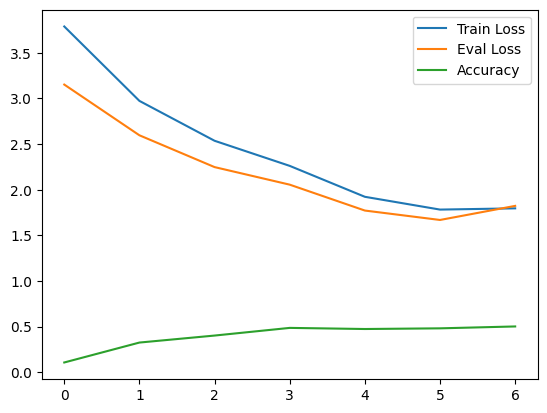

	 Iter [0/24]	 Loss: 1.821239
	 Iter [6/24]	 Loss: 1.732593
	 Iter [12/24]	 Loss: 1.797033
	 Iter [18/24]	 Loss: 1.839887
Epoch [8/100]	 Avg Train Loss: 1.715537	 Avg Eval Loss: 1.624898	 Avg Eval Accuracy: 0.50


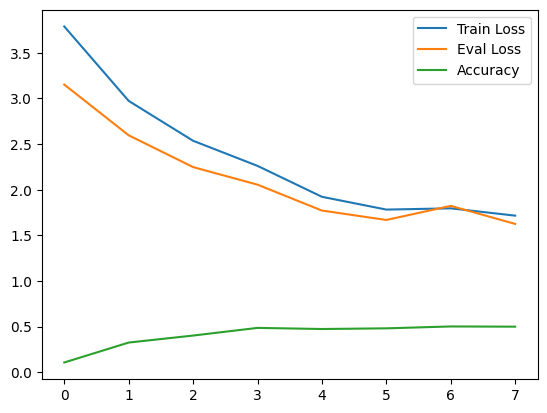

	 Iter [0/24]	 Loss: 1.533358
	 Iter [6/24]	 Loss: 1.591489
	 Iter [12/24]	 Loss: 1.730549
	 Iter [18/24]	 Loss: 1.685857
Epoch [9/100]	 Avg Train Loss: 1.649433	 Avg Eval Loss: 1.637679	 Avg Eval Accuracy: 0.51
	 Iter [0/24]	 Loss: 1.518312
	 Iter [6/24]	 Loss: 1.597275
	 Iter [12/24]	 Loss: 1.469198
	 Iter [18/24]	 Loss: 1.627286
Epoch [10/100]	 Avg Train Loss: 1.564377	 Avg Eval Loss: 1.511835	 Avg Eval Accuracy: 0.51
	 Iter [0/24]	 Loss: 1.486188
	 Iter [6/24]	 Loss: 1.553999
	 Iter [12/24]	 Loss: 1.471732
	 Iter [18/24]	 Loss: 1.432971
Epoch [11/100]	 Avg Train Loss: 1.492305	 Avg Eval Loss: 1.532540	 Avg Eval Accuracy: 0.52
	 Iter [0/24]	 Loss: 1.627182
	 Iter [6/24]	 Loss: 1.551975
	 Iter [12/24]	 Loss: 1.394936
	 Iter [18/24]	 Loss: 1.388846
Epoch [12/100]	 Avg Train Loss: 1.507296	 Avg Eval Loss: 1.547245	 Avg Eval Accuracy: 0.52
	 Iter [0/24]	 Loss: 1.477663
	 Iter [6/24]	 Loss: 1.435794
	 Iter [12/24]	 Loss: 1.294295
	 Iter [18/24]	 Loss: 1.522149
Epoch [13/100]	 Avg Train L

In [7]:
if __name__ == '__main__':
    trainer(dataset=vqa_v2)